# Stage 3 - Clustering of Skills associated to each PM Level

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import os
import tempfile
import numpy as np
import pandas as pd
import csv
import string
import json
import tensorflow as tf
import pickle
import copy

import operator
import math

import matplotlib.pyplot as plt
import seaborn as sns

#Import Document Set
from gensim import corpora, models, similarities
#from gensim.models.phrases import Phrases, Phraser
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Function to unpickle the files specified
def unpicke_file (path,filename):
    infile = infile = open( os.path.join(path,filename),'rb')
    pickObject = pickle.load(infile)
    infile.close()
    return pickObject

In [4]:
#Convert coordinates cartesian to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2) #radious
    phi = np.arctan2(y, x)     #angle
    return [rho, phi]

In [5]:
#Read a json file
def open_file(fname):
    with open(fname) as jsonfile:
            resumes = json.load(jsonfile)
    return resumes

In [6]:
#Function that creates an array for each of the skills detected in the profiles/resumes
def create_arr_by_skills(resumes):
    df=pd.DataFrame(resumes)
    job_desc=[]
    c=0
    for cv in df.Resume:
        puesto=cv["job"].lower()
    #     print(puesto)
        skill=""
        for skills in cv['skills_endorsment']:
            skill=skill+" "+skills['skill_name']+"\n"#.replace(" ","_")
        skill=skill.lower()
    #     print(skill)
    #         cat=skills['skill_category']
        if len(skill)>0:
            job_desc.append([puesto,skill])
            c=c+1
    print("Total CV's processed: {}".format(len(df.Resume)))
    print("Total CV's saved: {}".format(c))
    return job_desc   

# Jobs labeling Funtion 
def label_jobs(temp_file,job_desc):
    f= open(temp_file,"w+")
    jobs_labeled=[]
    documents=[]

    for job in job_desc:
        #Jobs Labeling
        if job[0].find("vice president")!= -1 or job[0].find("delivery manager")!= -1 or job[0].find(" vp ")!= -1 or job[0].find("svp ")!= -1:
            f.write("{} \t|\t vice president or equivalent\n".format(job[0]))
            label="vice president or equivalent"
        else :
            if job[0].find("president")!= -1:
                    f.write("{} \t|\t president or equivalent\n".format(job[0])) 
                    label="president or equivalent"
            else:            
                if job[0].find("director")!= -1:
                    f.write("{} \t|\t director or equivalent\n".format(job[0]))
                    label="director or equivalent"
                else:
                    if job[0].replace("sr","senior").find("senior project manager")!= -1 or (job[0].replace("sr","senior").find("senior")!= -1
                            and job[0].find("project manager")!= -1) or ( job[0].replace("programme","program").find("program")!= -1 and job[0].find("manager")!= -1):
                            f.write("{} \t|\t senior project manager or equivalent\n".format(job[0].replace("|",",")))
                            label="senior project manager or equivalent"
                    else:
                        if job[0].find("project manager")!= -1 or (job[0].find("project")!= -1 and job[0].replace("management","manager").find("manager")!= -1) or job[0].find("project coordinator")!= -1 or job[0].find("project consultant")!= -1 or (
                            job[0].find("manager")!= -1 ):
                            f.write("{} \t|\t project manager or equivalent\n".format(job[0].replace("|",",")))
                            label="project manager or equivalent"
                        else:
                            if job[0].find("leader")!= -1 or job[0].find("lead")!= -1:
                                f.write("{} \t|\t project leader or equivalent\n".format(job[0].replace("|",",")))
                                label="project leader or equivalent"
                            else:
                                if job[0].replace("sr","senior").find("senior")!= -1 or (job[0].find("technology")!= -1 and job[0].find("analyst")!= -1):
                                    f.write("{} \t|\t senior consultant or equivalent\n".format(job[0].replace("|",",")))
                                    label="senior consultant or equivalent"
                                else:
                                    if job[0].find("develop")!= -1 or job[0].find("system")!= -1 or job[0].find("tech")!= -1 or  job[0].find("analyst")!= -1 or  job[0].find("software")!= -1 or  job[0].find("it")!= -1 or  job[0].find("oracle")!= -1 or  job[0].find("consultant")!= -1 or  job[0].replace("jr","junior").find("junior")!= -1 or  job[0].find("engineer")!= -1:
                                        f.write("{} \t|\t it consultant or equivalent\n".format(job[0].replace("|",",")))
                                        label="it consultant or equivalent"
                                    else:
                                        f.write("{} \t|\t OOB\n".format(job[0].replace("|",",")))
                                        label="OOB"

        jobs_labeled.append([label,job[0],job[1].replace("\\n","\n").replace("   "," ").replace("  "," ").lower()])
    f.close()
    print("Archivo temporal creado en: {}".format(os.getcwd()))
    return documents,jobs_labeled

In [7]:
#Sentence tokenization
def token_separation(sDescription="",splitted=True,bSentence=False,bStopwords=False):
    
    sentenceTkn = []
    
    #Use of stopwords
    stoplist = []
    if bStopwords:
        stoplist = list(set(stopwords.words('english')))
        stoplist.extend(["–","/","&",".","$","(",")","!","?",";",":","'",",","“","”","’"])
    
    #Convert Description to sentence and Tokenization of words
    tnzr = nltk.tokenize
    if bSentence:
#         sentences= sDescription.split(".")
        sDescription=sDescription.replace(" \n ","\n").replace(" \n","\n").replace("\n ","\n").replace("\n",".\n<sen>").replace("..\n",".\n")
#         print(sDescription,"\n************")
        sentences = sent_tokenize(sDescription)
#         print(sentences)
        for sen in sentences:
            tnkstr= tnzr.word_tokenize(sen.replace("<sen>",""))
            
            i_offset = 0
            for i, t in enumerate(tnkstr):
                i -= i_offset
                if t == '#' and i > 0:
                    left = tnkstr[:i-1]
                    joined = [tnkstr[i - 1] + t]
                    right = tnkstr[i + 1:]
                    tnkstr = left + joined + right
                    i_offset += 1
    
            lSenTkn=[word for word in tnkstr if (word not in stoplist)]
            if len(lSenTkn)>0:
                if splitted:
                    sentenceTkn.append(lSenTkn)
                else:
                    sentenceTkn.extend(lSenTkn)
    else:
        sentences = sDescription
        tnkstr= tnzr.word_tokenize(sentences)   
        sentenceTkn = [word for word in tnkstr if (word not in stoplist)]

    return sentenceTkn

In [8]:
#Infering sentences
def infer_doc2vec(model_name,jobs_labeled):
    model = model_name

    lbl=[]
    emb=[]
    for job in jobs_labeled:
        model.random.seed(0)
        vecjob = model.infer_vector(doc_words=job)#, steps=20, alpha=0.025)
        emb.append(vecjob)
    
    docs_emb = {"Labels": lbl
               ,"Embedding": np.array(emb)}
    
    return emb


In [9]:

def bestOption (array,percentage,total):
    #Definition of the range of each of the categories.
    mustFlag = round (total * (1 - percentage ),0)
    avgFlag = round(mustFlag - (total * percentage),0)
    plusFlag = round(total * 0.25,0)
    
    #Set definition
    mustSet=[]
    avgSet=[]
    plusSet=[]
    for clus in array:
        if (clus[1]>=mustFlag and clus[0] not in mustSet):
            mustSet.append(clus[0])
        if ((clus[1]>=avgFlag and clus[1]<mustFlag)and clus[0] not in avgSet):
            avgSet.append(clus[0])
        if ((clus[1]>=plusFlag and clus[1]<avgFlag)and clus[0] not in plusSet):
            plusSet.append(clus[0])
    
    skillCat = []
    for cluster in mustSet:
        ltmustSkills=[]
        for clus in array:
            if clus[0] == cluster:
                ltmustSkills.append(clus)
        ltmustSkills.sort(key=lambda x:x[3], reverse = True)
        skillCat.append([ltmustSkills[0][0],ltmustSkills[0][1],ltmustSkills[0][2],ltmustSkills[0][3],"Necessary Skill"])
    
    for cluster in avgSet:
        ltmustSkills=[]
        for clus in array:
            if clus[0] == cluster:
                ltmustSkills.append(clus)
        ltmustSkills.sort(key=lambda x:x[3], reverse = True)
        skillCat.append([ltmustSkills[0][0],ltmustSkills[0][1],ltmustSkills[0][2],ltmustSkills[0][3],"General Skill"])
    
    for cluster in plusSet:
        ltmustSkills=[]
        for clus in array:
            if clus[0] == cluster:
                ltmustSkills.append(clus)
        ltmustSkills.sort(key=lambda x:x[3], reverse = True)
        skillCat.append([ltmustSkills[0][0],ltmustSkills[0][1],ltmustSkills[0][2],ltmustSkills[0][3],"Aggregated Value"])

    return skillCat

In [10]:
# Definition of the paths to be used
fpath= os.getcwd()
fname= 'C:\\Users\\Victor\\Documents\\LinkedIn Input/LinkedinCV(300)_2.json'
temp_file='JobsLabeledSk.txt'

In [11]:
resumes = open_file(fname)
job_desc = create_arr_by_skills(resumes)
_,jobs_labeled = label_jobs(temp_file,job_desc)

Total CV's processed: 300
Total CV's saved: 293
Archivo temporal creado en: C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding


In [12]:
#Tokenization of documents
jobSentnc_tkn = []
for d in jobs_labeled:
    jobSentnc_tkn.append([d[0],d[1],token_separation(d[2],bSentence=True,bStopwords=True)])

In [22]:
# jobSentnc_tkn

In [13]:
fpath= os.getcwd()
fmodelname = os.path.join(fpath,'Model/Doc2vecForSentences.model')
model = Doc2Vec.load(fmodelname)

2019-05-20 13:07:41,056 : INFO : loading Doc2Vec object from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model
2019-05-20 13:07:41,351 : INFO : loading trainables recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.trainables.* with mmap=None
2019-05-20 13:07:41,352 : INFO : loading wv recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.wv.* with mmap=None
2019-05-20 13:07:41,353 : INFO : loading vocabulary recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.vocabulary.* with mmap=None
2019-05-20 13:07:41,353 : INFO : loading docvecs recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.docvecs.* with mmap=None
2019-05-20 13:07:41,354 : INFO : loaded C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vec

In [14]:
jobSentence = jobSentnc_tkn

jobSenD2V=[]
for js in jobSentence:
    eSenbyDes=infer_doc2vec(model,js[2])
    jobSenD2V.append([js[0],js[1],js[2],eSenbyDes])    

In [15]:
fprepath= os.path.join(fpath,"CompletedPreprocessing/")
filename =os.path.join(fprepath,"SkillsEmbeddingLinkedin.p")
outfile = open(filename,'wb')
pickle.dump(jobSenD2V,outfile)
outfile.close()

## Import of file "SkillsEmbeddingLinkedin"

In [16]:
fpath= os.getcwd()
fprepath= os.path.join(fpath,"CompletedPreprocessing/")
filename =os.path.join(fprepath,"SkillsEmbeddingLinkedin.p")
infile = open(filename,'rb')
jobSenD2V = pickle.load(infile)
infile.close()

## Split by job level

In [17]:
SentenceSkillLinkedin = []
vpD2V=[]
prD2V=[]
drD2V=[]
pmD2V = []
spmD2V = []
plD2V = []
scD2V = []
ctD2V = []
for jse in jobSenD2V:
    if jse[0].find("vice president or equivalent")!= -1:
        vpD2V.append(jse[0:4])
    else:
        if jse[0].find("president or equivalent")!= -1:
            prD2V.append(jse[0:4])
        else:
            if jse[0].find("director or equivalent")!= -1:
                drD2V.append(jse[0:4])
            else:
                if jse[0].find("senior project manager or equivalent")!= -1:
                    spmD2V.append(jse[0:4])
                else:
                    if jse[0].find("project manager or equivalent")!= -1:  
                        pmD2V.append(jse[0:4])
                    else:
                        if jse[0].find("project leader or equivalent")!= -1:
                            plD2V.append(jse[0:4])
                        else:
                            if jse[0].find("senior consultant or equivalent")!= -1:
                                scD2V.append(jse[0:4])
                            else:
                                if jse[0].find("consultant or equivalent")!= -1:
                                    ctD2V.append(jse[0:4])
#                                 else: 
#                                     print("OOB ", jse[1])


print("Total number of profiles from Linkedin: {}\n".format(len(jobSenD2V)))

SentenceSkillLinkedin.append(ctD2V)
print("Total number of Consultants: ",len(ctD2V))
SentenceSkillLinkedin.append(scD2V)
print("Total number of Senior Consultants: ",len(scD2V))
SentenceSkillLinkedin.append(plD2V)
print("Total number of Project Leaders: ",len(plD2V))
SentenceSkillLinkedin.append(pmD2V)
print("Total number of PM: ",len(pmD2V))
SentenceSkillLinkedin.append(spmD2V)
print("Total number of Senior PM: ",len(spmD2V))
SentenceSkillLinkedin.append(drD2V)
print("Total number of Directors: ",len(drD2V))
SentenceSkillLinkedin.append(prD2V)
print("Total number of Presidents: ",len(prD2V))
SentenceSkillLinkedin.append(vpD2V)
print("Total number of Vice presidents: ",len(vpD2V), "\n")

print("Total number of job-tag: ",len(SentenceSkillLinkedin))
            

Total number of profiles from Linkedin: 293

Total number of Consultants:  65
Total number of Senior Consultants:  27
Total number of Project Leaders:  74
Total number of PM:  62
Total number of Senior PM:  40
Total number of Directors:  1
Total number of Presidents:  5
Total number of Vice presidents:  18 

Total number of job-tag:  8


## Creation of Clusters and frecuency calculation

******************** it consultant or equivalent ********************
Total number of profiles processed: 65
Total number of sentences: 1880 - 1880

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 254
Estimated number of noise points: 420


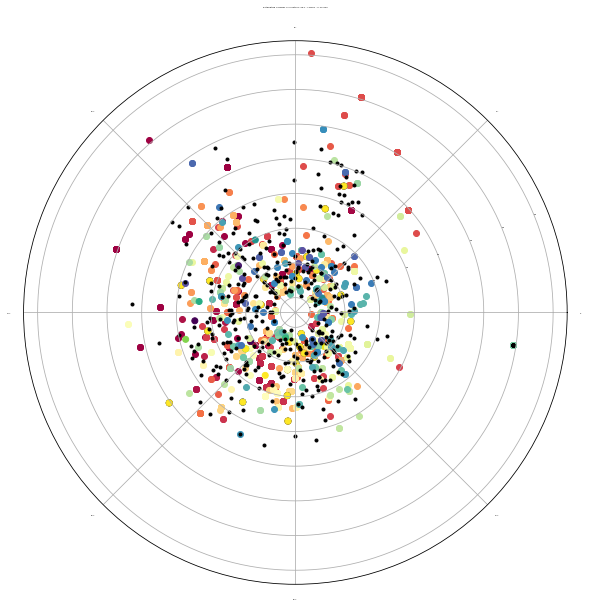


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 232
Estimated number of noise points: 396


<Figure size 432x288 with 0 Axes>

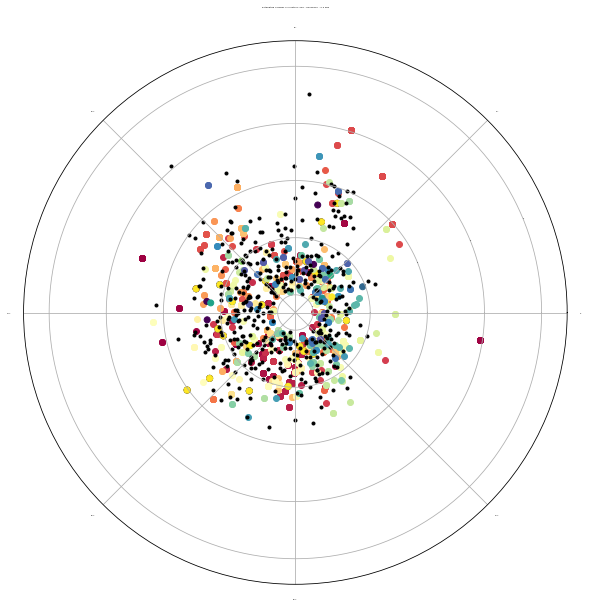

Total de habilidades filtradas y procesadas: 1395
******************** senior consultant or equivalent ********************
Total number of profiles processed: 27
Total number of sentences: 851 - 851

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 130
Estimated number of noise points: 220


<Figure size 432x288 with 0 Axes>

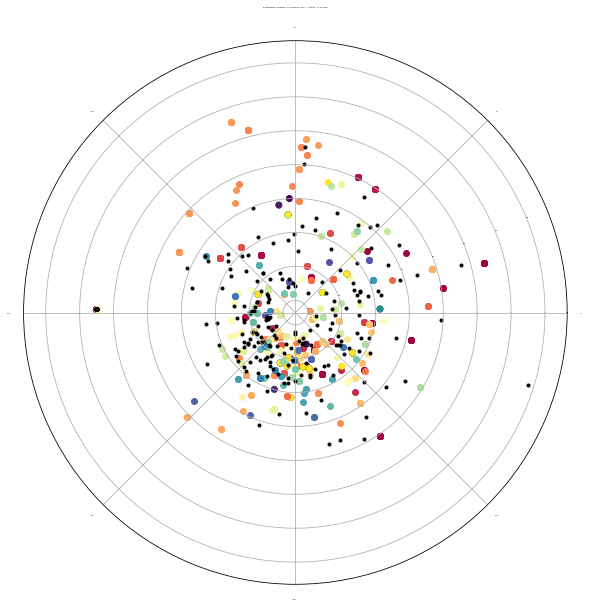


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 112
Estimated number of noise points: 204


<Figure size 432x288 with 0 Axes>

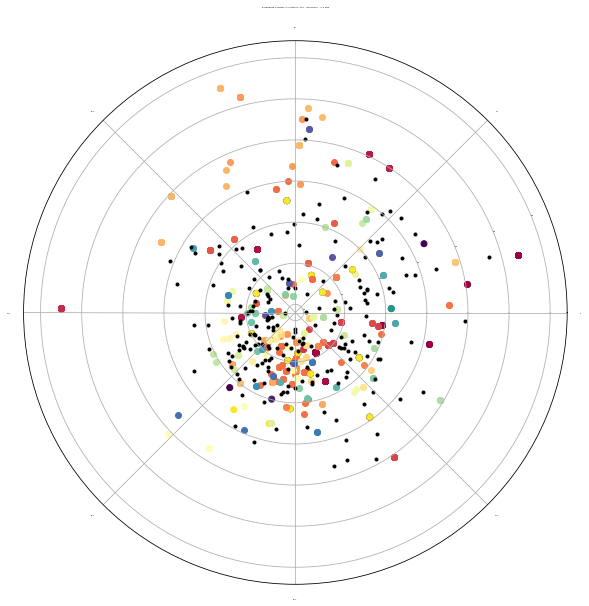

Total de habilidades filtradas y procesadas: 606
******************** project leader or equivalent ********************
Total number of profiles processed: 74
Total number of sentences: 2283 - 2283

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 271
Estimated number of noise points: 373


<Figure size 432x288 with 0 Axes>

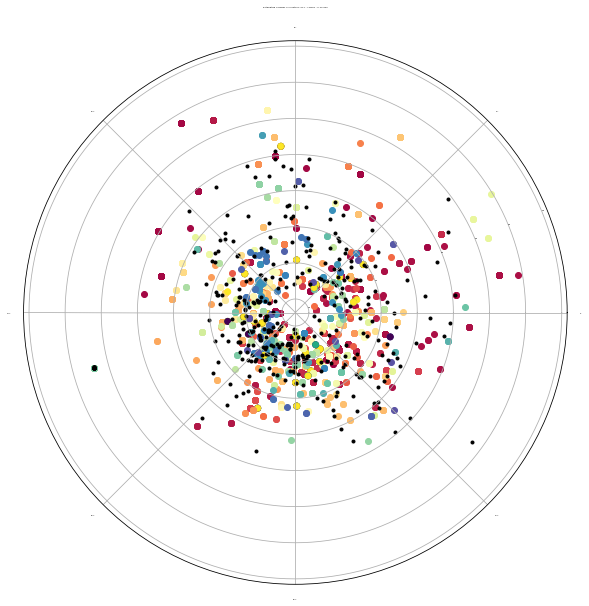


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 261
Estimated number of noise points: 350


<Figure size 432x288 with 0 Axes>

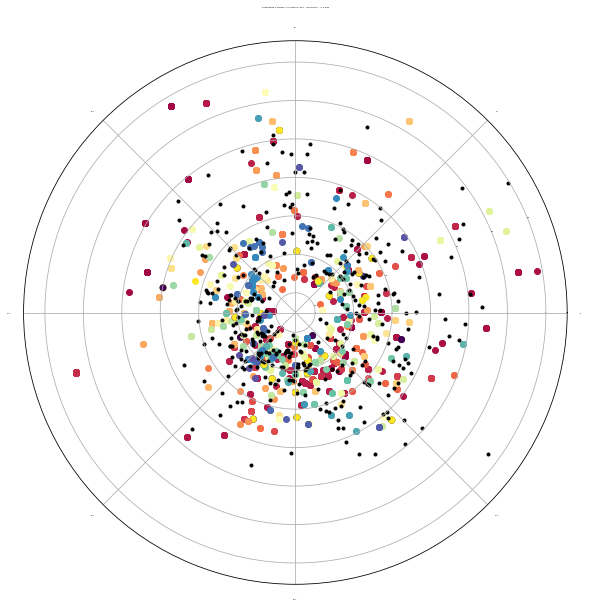

Total de habilidades filtradas y procesadas: 1859
******************** project manager or equivalent ********************
Total number of profiles processed: 62
Total number of sentences: 2075 - 2075

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 261
Estimated number of noise points: 400


<Figure size 432x288 with 0 Axes>

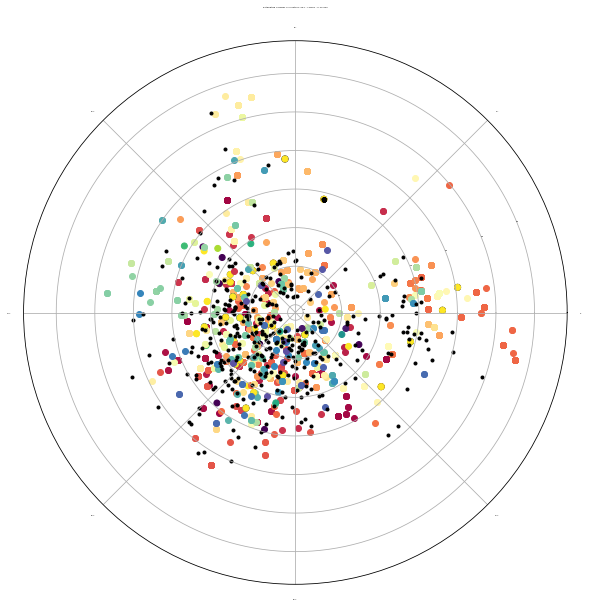


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 252
Estimated number of noise points: 393


<Figure size 432x288 with 0 Axes>

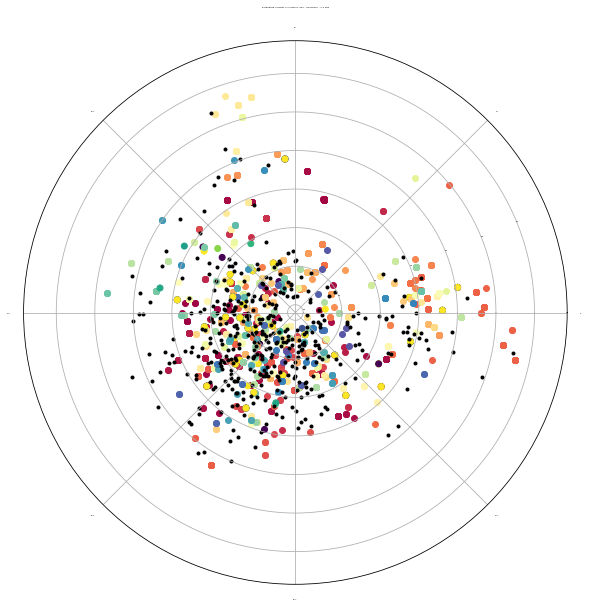

Total de habilidades filtradas y procesadas: 1607
******************** senior project manager or equivalent ********************
Total number of profiles processed: 40
Total number of sentences: 1369 - 1369

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 179
Estimated number of noise points: 284


<Figure size 432x288 with 0 Axes>

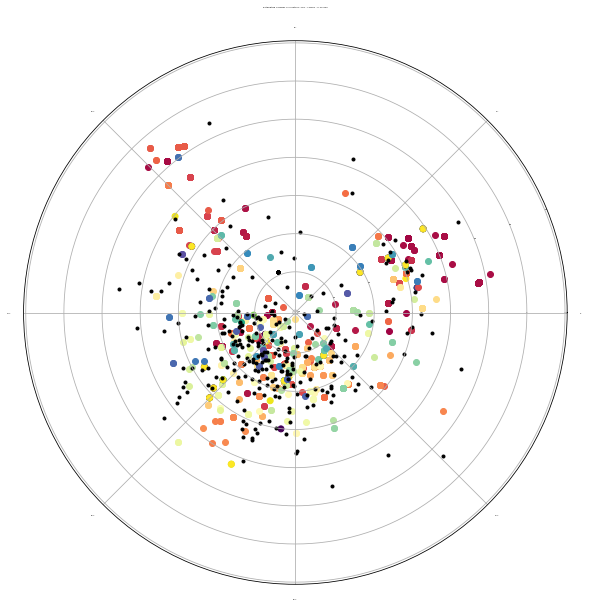


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 176
Estimated number of noise points: 288


<Figure size 432x288 with 0 Axes>

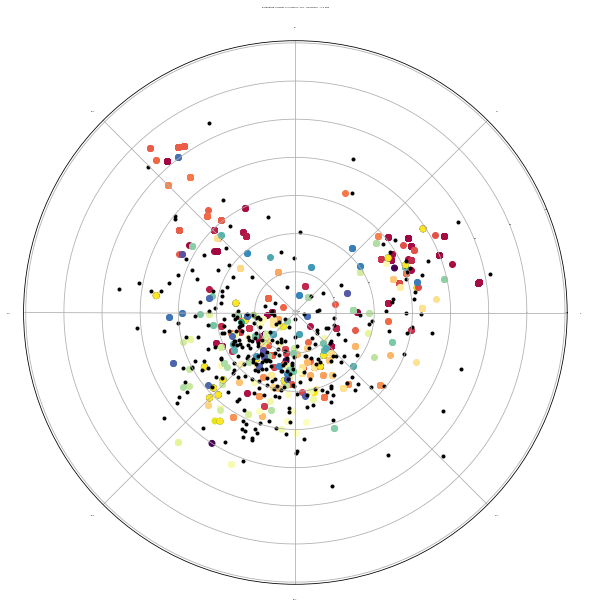

Total de habilidades filtradas y procesadas: 1043
******************** director or equivalent ********************
Total number of profiles processed: 1
Total number of sentences: 33 - 33

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 3
Estimated number of noise points: 27


<Figure size 432x288 with 0 Axes>

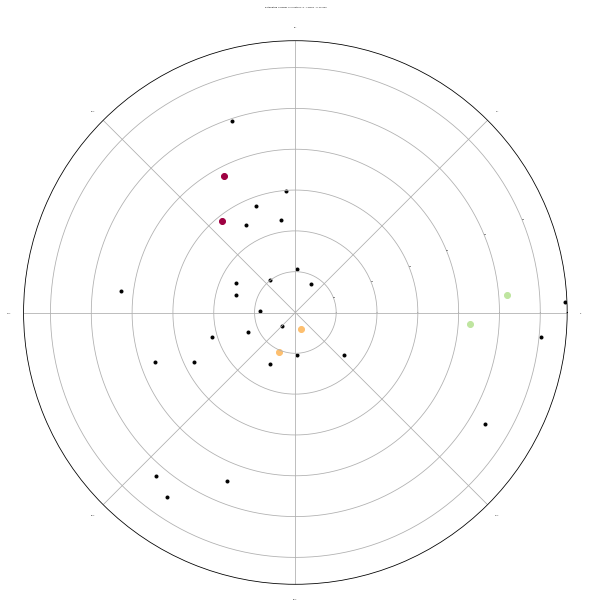


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 3
Estimated number of noise points: 26


<Figure size 432x288 with 0 Axes>

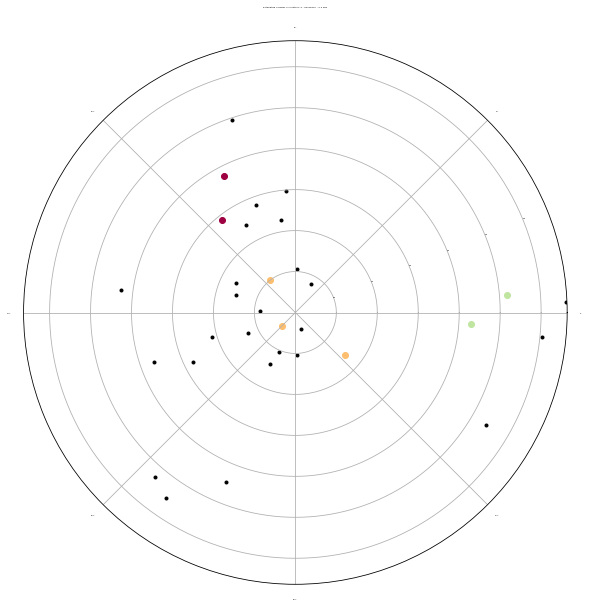

Total de habilidades filtradas y procesadas: 4
******************** president or equivalent ********************
Total number of profiles processed: 5
Total number of sentences: 196 - 196

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 59
Estimated number of noise points: 40


<Figure size 432x288 with 0 Axes>

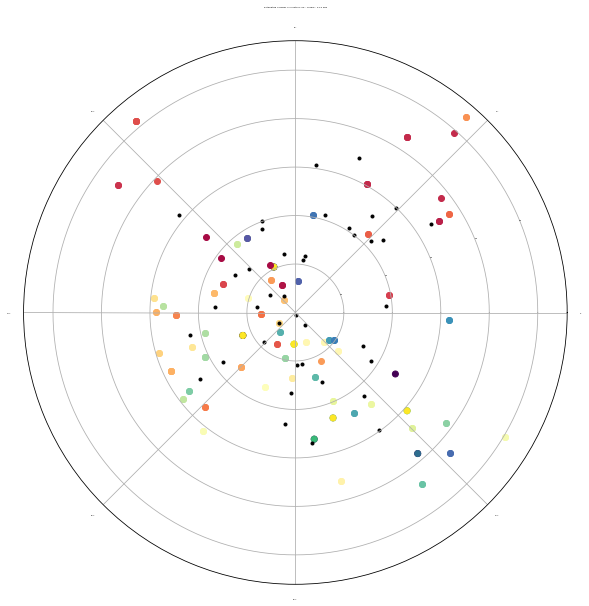


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 63
Estimated number of noise points: 38


<Figure size 432x288 with 0 Axes>

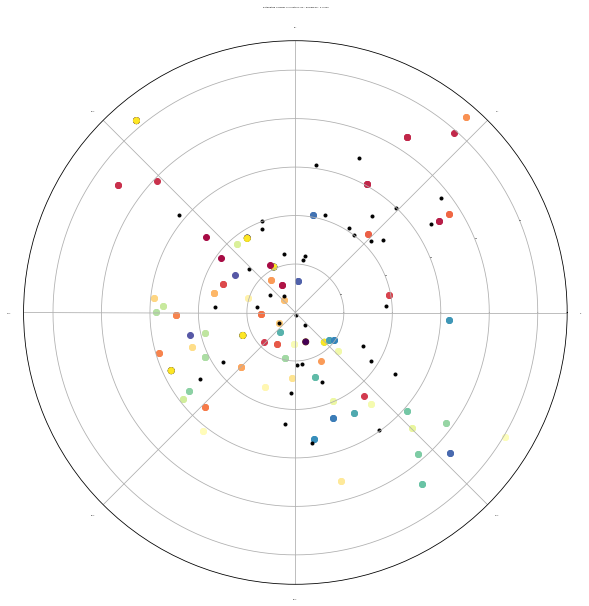

Total de habilidades filtradas y procesadas: 154
******************** vice president or equivalent ********************
Total number of profiles processed: 18
Total number of sentences: 526 - 526

###############################################
Metric: cosine
Eps: 0.12
Min Samples: 2
Estimated number of clusters: 81
Estimated number of noise points: 154


<Figure size 432x288 with 0 Axes>

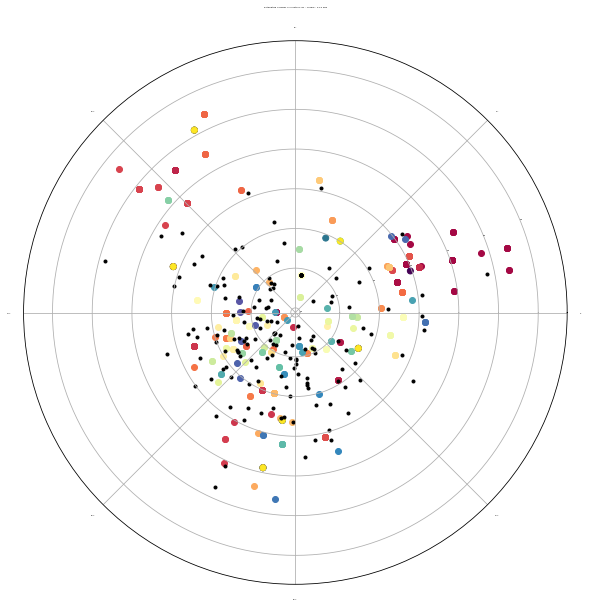


###############################################
Metric: euclidean
Eps: 2.3
Min Samples: 2
Estimated number of clusters: 81
Estimated number of noise points: 146


<Figure size 432x288 with 0 Axes>

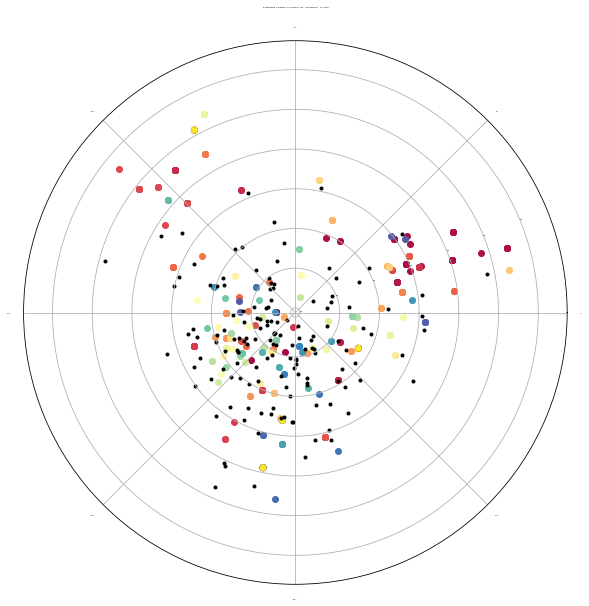

Total de habilidades filtradas y procesadas: 359


<Figure size 432x288 with 0 Axes>

In [37]:
for i in range (0,len(SentenceSkillLinkedin)):
    
    ###############CREATE A DIRECTORY FOR EACH JOB###############################
    dirname =os.path.join(fprepath,SentenceSkillLinkedin[i][0][0].replace(" ","_"))

    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    print("********************",SentenceSkillLinkedin[i][0][0],"********************")
    sent2Vec=[]
    cc=0
    for c,job in enumerate(SentenceSkillLinkedin[i]):
        for s in zip(job[2],job[3]):
            cc=cc+1
#             print([" ".join(s[0]),s[1]])
            sent2Vec.append([" ".join(s[0]),s[1]])
    print("Total number of profiles processed: {}".format(c+1))
    print("Total number of sentences: {} - {}".format(len(sent2Vec),cc))
    jsenemb=[]
    jsenskill=[]
    for js in sent2Vec:
        jsenemb.append(js[1])  
        jsenskill.append(js[0])
        
    outfile = open(os.path.join(dirname,"skillEmbeding_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(jsenemb,outfile)
    outfile.close()
    
    outfile = open(os.path.join(dirname,"skillSentence_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(jsenskill,outfile)
    outfile.close()
         
    ##############################################################################
    ############                    Compute DBSCAN                   #############
    ##############################################################################
    
    minSamples=[2]
    eps = [0.12,2.3]

    jsenemb = np.asarray(jsenemb)
    mets = ['cosine','euclidean']#,'canberra','hamming']#'euclidean'#'cosine'
    
    for met in mets:
        print("\n###############################################")
        print('Metric: %s' %met)
        for ep in eps:            
            if (met == 'cosine' and ep != 2.3) or (met == 'euclidean' and ep != 0.12):
                print('Eps: {}'.format(ep))
                for minsample in minSamples:
                    dbscan_model = DBSCAN(eps=ep, min_samples=minsample,metric=met)
                    x = dbscan_model.fit(jsenemb)
                    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
                    core_samples_mask[dbscan_model.core_sample_indices_] = True
#                     labels = dbscan_model.labels_
                    exec("labels_{}= dbscan_model.labels_".format(met))
    
                    exec("labels=labels_{}".format(met))

                # Number of clusters in labels, ignoring noise if present.
                    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                    n_noise_ = list(labels).count(-1)

                    print('Min Samples: {}'.format(minsample))
                    print('Estimated number of clusters: %d' % n_clusters_)
                    print('Estimated number of noise points: %d' % n_noise_)

                    #Calculation of Principal Component analysis
                    pca = PCA(n_components=2).fit(jsenemb)
                    datapoint = pca.transform(jsenemb)

                    #####################################################
                    ###                   Plot result                 ###
                    #####################################################
                    
                    unique_labels = set(labels)
                    colors = [plt.cm.Spectral(each)
                              for each in np.linspace(0, 1, len(unique_labels))]

                    fig = plt.figure(figsize=(20,10))
                    ax= fig.add_subplot(111,projection='polar')

                    for k, col in zip(unique_labels, colors):
                        if k == -1:
                            # Black used for noise.
                            col = [0, 0, 0, 1]

                        class_member_mask = (labels == k)

                        xy = datapoint[class_member_mask & core_samples_mask]
                        polars=[]
                        for point in xy:
                            polar = cart2pol(point[0], point[1])
                            polars.append(polar)

                        r=[]
                        theta=[]
                        for cp in polars:
                            r.append(cp[0])
                            theta.append(cp[1])

                        ax.set_rmax(0.012)
                        c = ax.scatter(theta, r,c=tuple(col),marker = 'o')
                        plt.rcParams.update({'font.size': 6})

                        # Black removed and is used for noise instead.
                        xy = datapoint[class_member_mask & ~core_samples_mask]
                        polars=[]
                        for point in xy:
                            polar = cart2pol(point[0], point[1])
                            polars.append(polar)

                        r=[]
                        theta=[]
                        for cp in polars:
                            r.append(cp[0])
                            theta.append(cp[1])

                        cnp = ax.scatter(theta, r,c=tuple(col),marker=".")
                        plt.rcParams.update({'font.size': 2})

#                         ax.legend(unique_labels)
#                         fig.show()

        #             plt.margins(x=0, y=-0.45)   # Values in (-0.5, 0.0) zooms in to center

                    plt.title('Estimated number of clusters: {} - {} - {} eps'.format(n_clusters_,met,ep))
                    plt.show()
                    plt.savefig(os.path.join(dirname,"PolarSkills_{}_{}_eps".format(n_clusters_,met)) + '.png', dpi = 300)
    
                    outfile = open(os.path.join(dirname,"labels_{}.p".format(met)),'wb')
                    exec("pickle.dump(labels_{},outfile)".format(met))
                    outfile.close()
                
    ####################################################################
    #############           SKILLS COMPUTATION           ###############
    ####################################################################
                    
    fnameCos ="labels_cosine.p"
    fnameEuc ="labels_euclidean.p"
    fnamesemb = "skillEmbeding_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))
    fnamessen = "skillSentence_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))
    
    CosineLabels = unpicke_file(dirname,fnameCos)
    EuclideanLabels = unpicke_file(dirname,fnameEuc)
    skillEmb = unpicke_file(dirname,fnamesemb)
    skillSen = unpicke_file(dirname,fnamessen)
    
    #Discrimination of habilities by comparing the clusters generated by the DBSCAN
    newlist = []
    mas=0
    for n in range(len(skillSen)):
        if CosineLabels[n] != -1 and EuclideanLabels[n] !=-1:
            mas=mas+1
            if [CosineLabels[n],skillSen[n]] not  in newlist:
                newlist.append([CosineLabels[n],skillSen[n]])
    print("Total de habilidades filtradas y procesadas: {}".format(mas))
    
    orderedlist = sorted(newlist)
#     for x in orderedlist:
#         print("{},{}".format(x[1],x[0]))
    df= pd.DataFrame(orderedlist)
    df.columns=['Cluster','Skill_Name']
    
    #Creation of Dictionary for future queries
    SkillDict = df.to_dict()
    
    
    lskill= list(df['Skill_Name'])
    
    #List to control and count the clusters and skills to be analyzed
    listSkills=[]
    listClust=[]
    for c,job in enumerate(SentenceSkillLinkedin[i]):
        cluster=[]
        for s in job[2]:
            skill = " ".join(s)
            if skill in lskill:                
                cluster.append(orderedlist[lskill.index(skill)][0])
                listSkills.append(skill)
        setclust=set(cluster)
        listClust.extend(list(setclust))

    lTotClust=list(set(listClust))
    lTotSkill=list(set(listSkills))
    
    #Frecuency by word in each cluster
    counterClustSkill=[]
    for cclr in lTotClust:
        for skill in lTotSkill:
            if orderedlist[lskill.index(skill)][0] == cclr:
                counterClustSkill.append([cclr,listClust.count(cclr),skill,listSkills.count(skill)])
                
    #Ordering of the list generated
    counterClustSkill.sort(key=lambda x:x[1], reverse = True)
    
#     for x in counterClustSkill:
#         print("{},{},{},{}".format(x[0],x[1],x[2],x[3]))

    #********************************************************************************
    #********************* Collection of skills*************************************
    skillcat=bestOption(counterClustSkill,.33,c+1)
    skillcat = pd.DataFrame(skillcat,columns=["Cluster Label","Cluster freq.","Skill","Skill freq","Category"])
    skillcat.to_csv(os.path.join(dirname,"SkillCategorization_{}.csv".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))))
    
    outfile = open(os.path.join(dirname,"ClusterSkillDict_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(SkillDict,outfile)
    outfile.close()
    
    outfile = open(os.path.join(dirname,"ClusterSkillSummaryDict_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(skillcat.to_dict(),outfile)
    outfile.close()
    